In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [56]:
from datetime import datetime
dateparse = lambda x: datetime.timestamp(datetime.strptime(x, '%Y-%m-%d'))

df = pd.read_csv('a10.csv', index_col='date', parse_dates=['date'])

In [72]:
df

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


In [65]:
# Let's keep the last 40% of the values out for testing purposes
train_size = 0.6
index = round(train_size*df.shape[0])

df_train = df.iloc[:index]
df_test = df.iloc[index:]

In [66]:
y_pred = df_test.shift(1)
y_pred

,value
date,
2001-09-01,NaN
2001-10-01,10.647060
2001-11-01,12.652134
2001-12-01,13.674466
2002-01-01,12.965735
...,...
2008-02-01,29.665356
2008-03-01,21.654285
2008-04-01,18.264945


In [67]:
from sklearn.metrics import r2_score

y_pred = df_test.shift(1).dropna()
y_true = df_test[1:]

print(f"R2: {r2_score(y_true, y_pred)}")

R2: 0.5069517261286796


In [71]:
df.shift(1)

,value
date,
1991-07-01,NaN
1991-08-01,3.526591
1991-09-01,3.180891
1991-10-01,3.252221
1991-11-01,3.611003
...,...
2008-02-01,29.665356
2008-03-01,21.654285
2008-04-01,18.264945


In [68]:
df2 = df.copy(); df2_train = df_train.copy(); df2_test = df_test.copy()

for i in range(1, 13):
    df2_train[f't - {i}'] = df_train['value'].shift(i)
    df2_test[f't - {i}'] = df_test['value'].shift(i)

df2_train.dropna(inplace=True)
df2_test.dropna(inplace=True)

df2_train.head()

,value,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12
date,,,,,,,,,,,,,
1992-07-01,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003,3.252221,3.180891,3.526591
1992-08-01,3.558776,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003,3.252221,3.180891
1992-09-01,3.777202,3.558776,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003,3.252221
1992-10-01,3.924490,3.777202,3.558776,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003
1992-11-01,4.386531,3.924490,3.777202,3.558776,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869


In [69]:
# Train Test Split
X2_train = df2_train.drop(columns = ['value'])
y2_train = df2_train['value']
X2_test = df2_test.drop(columns = ['value'])
y2_test = df2_test['value']

print(X2_train.shape,y2_train.shape, X2_test.shape,y2_test.shape)

(110, 12) (110,) (70, 12) (70,)


R2:  0.8580874548863759


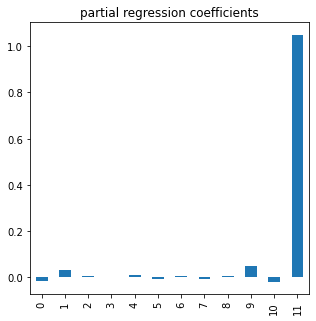

In [70]:
from sklearn.linear_model import LinearRegression
# Predict and measure R2
model = LinearRegression()
model = model.fit(X2_train, y2_train)

print('R2: ', r2_score(y2_test, model.predict(X2_test)))
pd.Series(model.coef_).plot(kind='bar')
plt.title('partial regression coefficients');

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

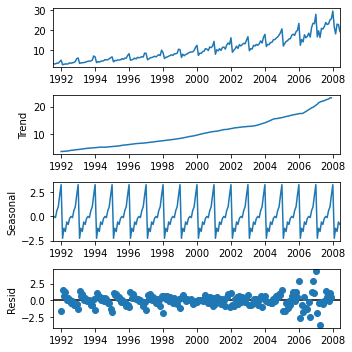

In [62]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df, model='additive')
result_add.plot();

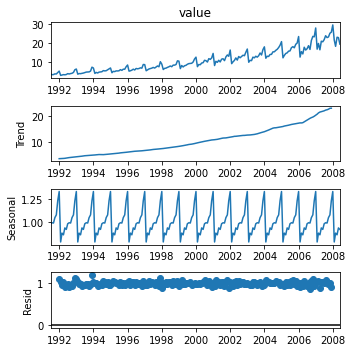

In [74]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_mul = seasonal_decompose(df['value'], model='multiplicative')
result_mul.plot();

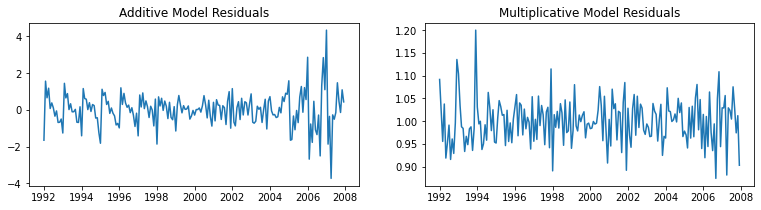

In [75]:
# Plot the residuals with "result_add.resid" to decide
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
ax1.plot(result_add.resid); ax1.set_title("Additive Model Residuals")
ax2.plot(result_mul.resid); ax2.set_title("Multiplicative Model Residuals");

In [76]:
# Stationary TS with small autocorrelation but stronger "variance"
plot_stationary_ts(ar1=0.4, sigma=3);

NameError: name 'plot_stationary_ts' is not defined

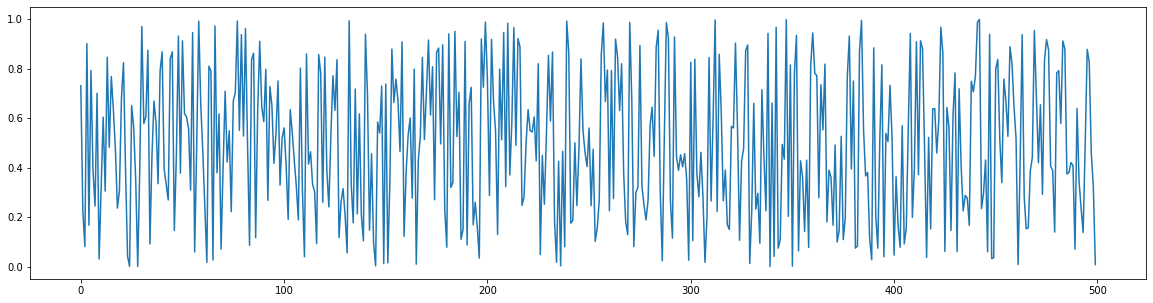

In [80]:
# White noise has no information to extract!
import scipy
plt.figure(figsize=(20,5));
plt.plot(np.arange(500), [scipy.stats.uniform().rvs() for i in np.arange(500)]);

In [81]:
from statsmodels.tsa.stattools import adfuller

adfuller(df.value)[1]  # p-value

1.0

In [82]:
print('additive resid: ', adfuller(result_add.resid.dropna())[1])
print('multiplicative resid: ', adfuller(result_mul.resid.dropna())[1])

additive resid:  0.0002852221054737602
multiplicative resid:  1.7472595795332862e-07


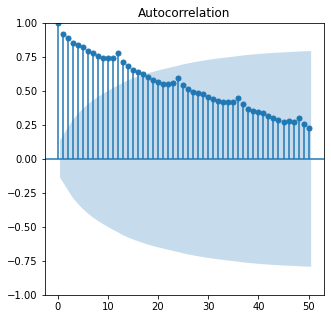

In [83]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.value, lags=50)
plt.show()

/Users/jinruwu/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


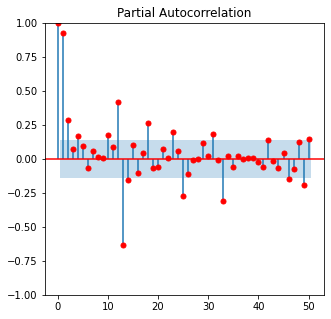

In [86]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df.value, lags=50, c='r');

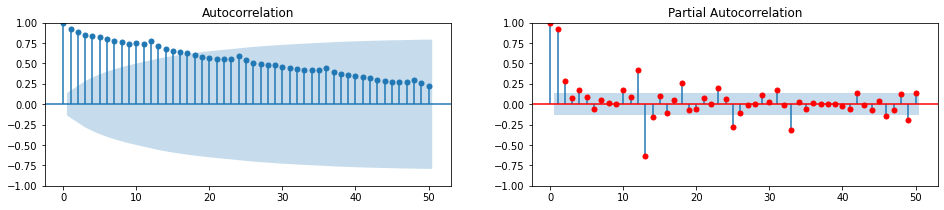

In [87]:
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(df.value, lags=50, ax=axes[0]);
plot_pacf(df.value, lags=50, ax=axes[1], color='r');

In [88]:
non_differenced_data = pd.Series([7, 4, 4, 6, 8, 6])
differenced_1 = non_differenced_data.diff()
print(differenced_1)

0    NaN
1   -3.0
2    0.0
3    2.0
4    2.0
5   -2.0
dtype: float64


In [90]:
print(differenced_1.diff())

0    NaN
1    NaN
2    3.0
3    2.0
4    0.0
5   -4.0
dtype: float64


date
1991-07-01         NaN
1991-08-01   -0.345700
1991-09-01    0.071330
1991-10-01    0.358782
1991-11-01   -0.045134
                ...   
2008-02-01   -8.011071
2008-03-01   -3.389340
2008-04-01    4.842732
2008-05-01   -0.195167
2008-06-01   -3.480770
Name: value, Length: 204, dtype: float64


<AxesSubplot:xlabel='date'>

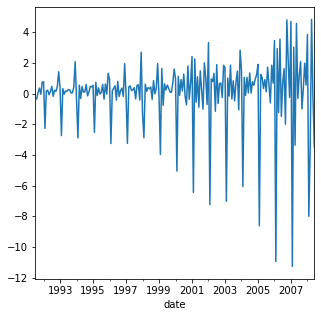

In [96]:
non_differenced_data = df['value']
differenced_1 = non_differenced_data.diff()
print(differenced_1)
differenced_1.plot()

In [95]:
print(differenced_1.diff())

date
1991-07-01          NaN
1991-08-01          NaN
1991-09-01     0.417030
1991-10-01     0.287452
1991-11-01    -0.403916
                ...    
2008-02-01   -11.870337
2008-03-01     4.621731
2008-04-01     8.232072
2008-05-01    -5.037899
2008-06-01    -3.285603
Name: value, Length: 204, dtype: float64


<AxesSubplot:xlabel='date'>

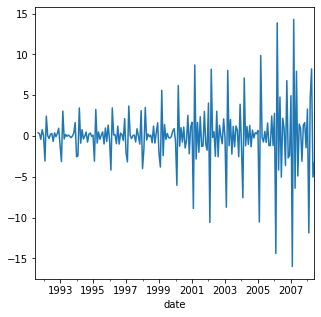

In [97]:
differenced_1.diff().plot()

<AxesSubplot:xlabel='date'>

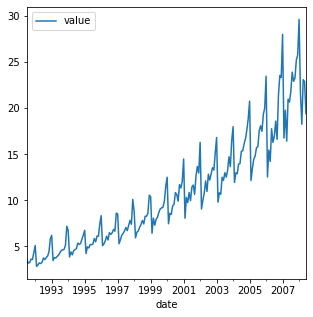

In [98]:
df.plot()

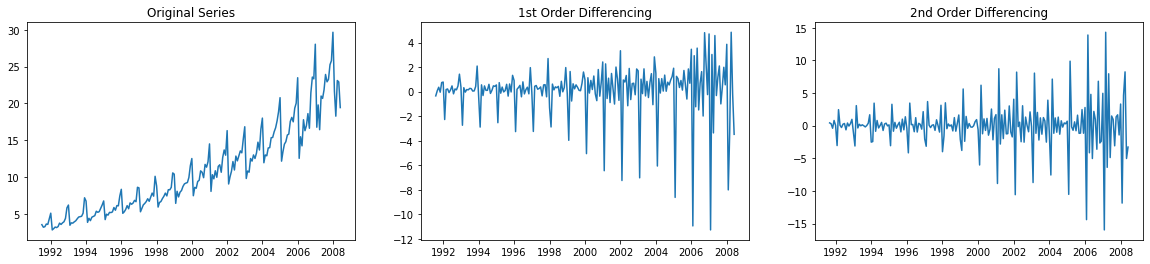

In [99]:
zero_diff = df.value
first_order_diff = df.value.diff(1)
second_order_diff = df.value.diff(1).diff(1)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');

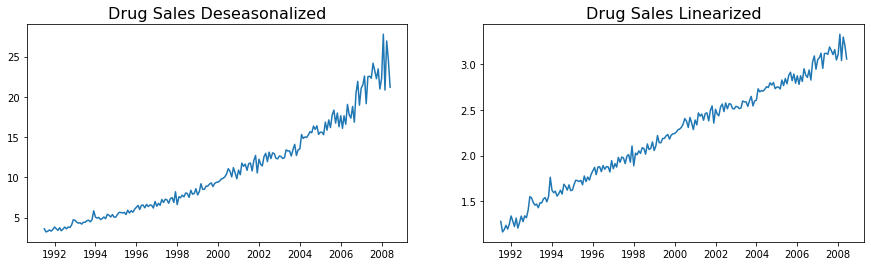

In [100]:
# Let's remove seasons
df['deseasonalized'] = df.value.values/result_mul.seasonal

plt.figure(figsize=(15,4)); plt.subplot(1,2,1); plt.plot(df.deseasonalized);
plt.title('Drug Sales Deseasonalized', fontsize=16);

# Also remove exponential trend 
df['linearized'] = np.log(df['deseasonalized'])

plt.subplot(1,2,2); plt.plot(df['linearized'])
plt.title('Drug Sales Linearized', fontsize=16);

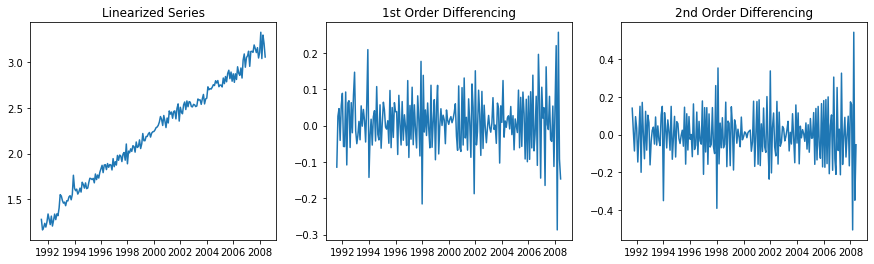

In [101]:
# Let's difference this and look at the ACFs
fig, axes = plt.subplots(1, 3,figsize=(15,4))

axes[0].plot(df['linearized']); axes[0].set_title('Linearized Series')
# 1st Differencing
y_diff = df['linearized'].diff().dropna()
axes[1].plot(y_diff); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
y_diff_diff = df['linearized'].diff().diff().dropna()
axes[2].plot(y_diff_diff); axes[2].set_title('2nd Order Differencing');

In [102]:
# check with ADF Test for stationarity
print('p-value zero-diff: ', adfuller(df['linearized'])[1])
print('p-value first-diff: ', adfuller(df['linearized'].diff().dropna())[1])
print('p-value second-diff: ', adfuller(df['linearized'].diff().diff().dropna())[1])

p-value zero-diff:  0.7134623265852262
p-value first-diff:  1.0092820652729728e-09
p-value second-diff:  1.3181782398652453e-12


In [105]:
# automatically estimate differencing term
from pmdarima.arima.utils import ndiffs
ndiffs(df['linearized'])

1

/Users/jinruwu/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


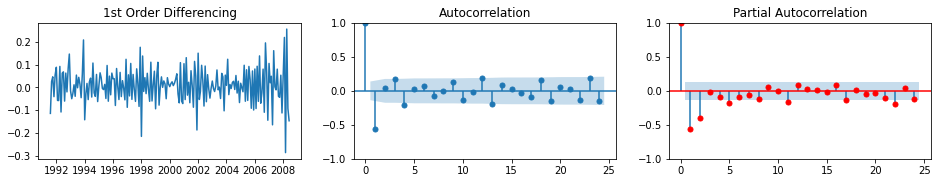

In [106]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(y_diff); axes[0].set_title('1st Order Differencing')
plot_acf(y_diff, ax=axes[1]);
plot_pacf(y_diff, ax=axes[2], c='r');

In [107]:
# from statsmodels.tsa.arima_model import ARIMA #statsmodels 0.11
from statsmodels.tsa.arima.model import ARIMA  #statsmodels 0.12+

arima = ARIMA(df['linearized'], order=(2, 1, 1), trend='t')
arima = arima.fit()

/Users/jinruwu/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jinruwu/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jinruwu/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jinruwu/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [108]:
arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             linearized   No. Observations:                  204
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 291.326
Date:                Thu, 28 Jul 2022   AIC                           -572.651
Time:                        07:51:28   BIC                           -556.085
Sample:                    07-01-1991   HQIC                          -565.949
                         - 06-01-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0097      0.001     11.610      0.000       0.008       0.011
ar.L1         -0.1419      0.095     -1.491      0.136      -0.328       0.045
ar.L2          0.0290      0.088      0.330      0.742      -0.144       0.202
ma.L1         -0.7891      0.078    -10.164      0.000      -0.941      -0.637
sigma2         0.0033      0.000     12.309      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                26.46
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                             0.47
Prob(H) (two-sided):                  0.25   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [109]:
import pmdarima as pm
smodel = pm.auto_arima(df['linearized'],
                       start_p=1, max_p=2,
                       start_q=1, max_q=2,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-555.440, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-453.201, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-527.228, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-533.804, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-453.201, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-560.953, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-562.744, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-562.744, Time=0.04 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.558 seconds


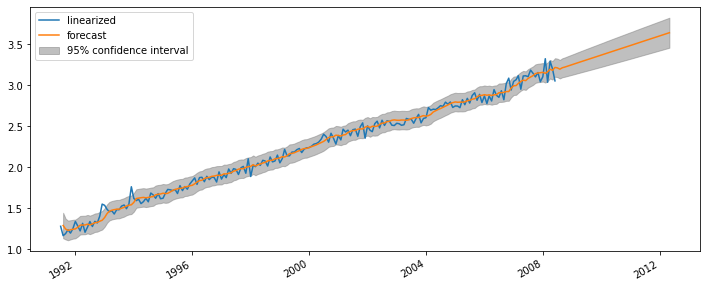

In [110]:
from statsmodels.graphics.tsaplots import plot_predict

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(df['linearized'], label='linearized')
plot_predict(arima, start=1, end=250, ax=axs);

In [111]:
# Create a correct train_test_split to predict the last 50 points
train = df['linearized'][0:150]
test = df['linearized'][150:]

# Build model
arima = ARIMA(train, order=(2, 1, 0), trend='t')  
arima = arima.fit()

## Forecast
# Forecast values
forecast = arima.forecast(len(test), alpha=0.05)  # 95% confidence

# Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

/Users/jinruwu/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jinruwu/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jinruwu/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [112]:
# We define here a "Plot forecast vs. real", which also shows historical training set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

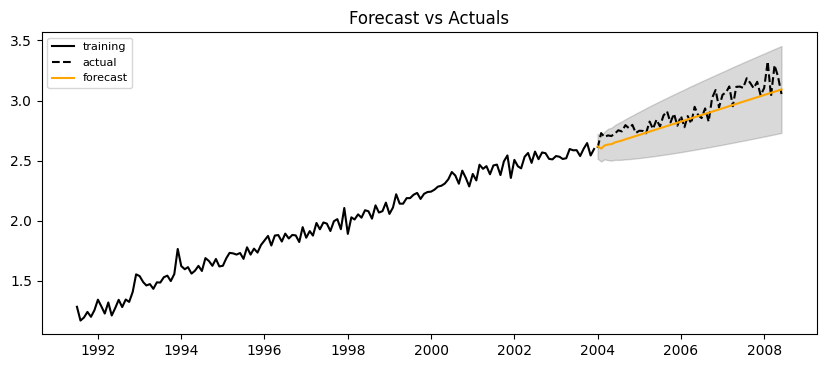

In [113]:
plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1])


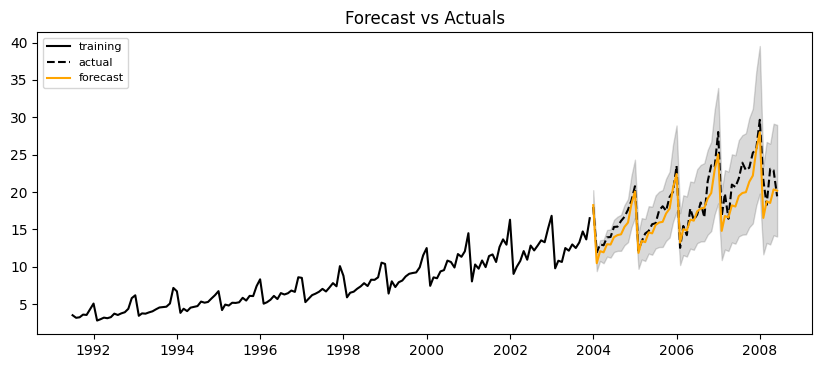

In [114]:
# Re-compose back to initial TS

forecast_recons = np.exp(forecast) * result_mul.seasonal[150:]
train_recons = np.exp(train) * result_mul.seasonal[0:150]
test_recons = np.exp(test) * result_mul.seasonal[150:]
lower_recons = np.exp(confidence_int)[:, 0] * result_mul.seasonal[150:]
upper_recons = np.exp(confidence_int)[:, 1] * result_mul.seasonal[150:]

# Plot
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)

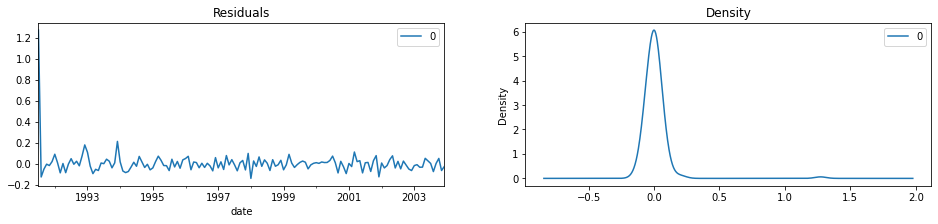

In [115]:
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

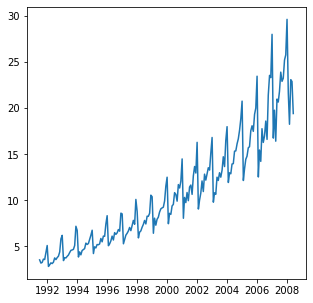

In [116]:
plt.plot(df.value);


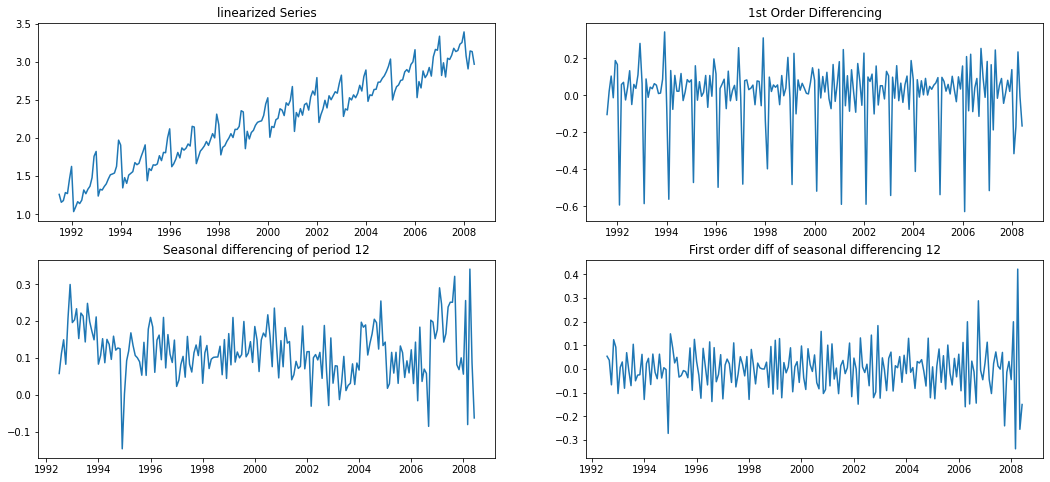

In [117]:
fig, axs = plt.subplots(2, 2, figsize=(18,8))
# keeping just log transform to stay ~ linear
df['log'] = np.log(df.value)

# linearized series
axs[0,0].plot(df.log); axs[0,0].set_title('linearized Series')

# Normal differencing
axs[0,1].plot(df.log.diff(1)); axs[0,1].set_title('1st Order Differencing')

# Seasonal differencing
axs[1,0].plot(df.log.diff(12))
axs[1,0].set_title('Seasonal differencing of period 12')

# Sesonal + Normal differencing
axs[1,1].plot(df.log.diff(12).diff(1))
axs[1,1].set_title('First order diff of seasonal differencing 12');

In [118]:
# Create a correct Training/Test split to predict the last 50 points
train = df.log[0:150]
test = df.log[150:]

In [119]:
smodel = pm.auto_arima(train, seasonal=True, m=12, 
                       start_p=0, max_p=1, max_d=1, start_q=0, max_q=1,
                       start_P=0, max_P=2, max_D=1, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-83.662, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-85.171, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-190.471, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-315.673, Time=0.23 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=-326.574, Time=0.70 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=-366.805, Time=0.83 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-379.630, Time=0.81 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.3

In [121]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(train, order=(0, 1, 1), seasonal_order=(2, 0, 2, 12))
sarima = sarima.fit(maxiter=75)

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

/Users/jinruwu/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jinruwu/Projects/le_wagon_lectures/lewagon/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.91380D-01    |proj g|=  4.90088D+00

At iterate    5    f= -1.31918D+00    |proj g|=  1.64732D+00

At iterate   10    f= -1.33498D+00    |proj g|=  2.50289D+00

At iterate   15    f= -1.36733D+00    |proj g|=  3.12050D-01

At iterate   20    f= -1.36770D+00    |proj g|=  2.98397D-02

At iterate   25    f= -1.37466D+00    |proj g|=  1.90719D-01

At iterate   30    f= -1.37491D+00    |proj g|=  3.55670D-02

At iterate   35    f= -1.37702D+00    |proj g|=  9.41421D-02

At iterate   40    f= -1.39741D+00    |proj g|=  1.04730D+00

At iterate   45    f= -1.40298D+00    |proj g|=  7.95929D-02

At iterate   50    f= -1.40551D+00    |proj g|=  1.28326D-01

At iterate   55    f= -1.40567D+00    |proj g|=  2.00475D-02

At iterate   60    f= -1.40568D+00    |proj g|=  2.44388D-03

At iterate   65    f= -1.4

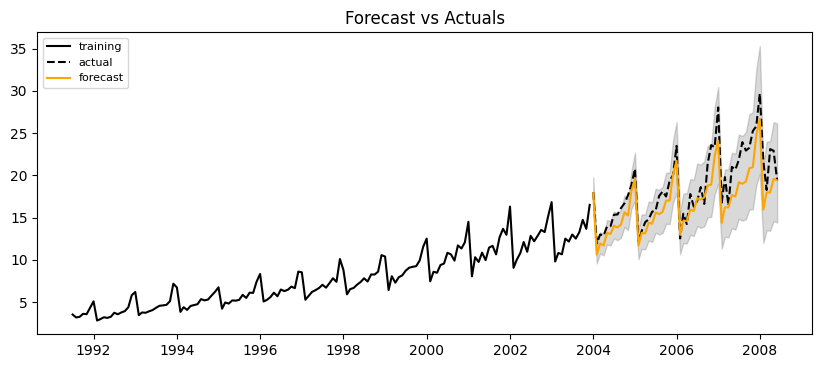

In [122]:
# Reconstruct by taking exponential
forecast_recons = pd.Series(np.exp(forecast), index=test.index)
lower_recons = np.exp(confidence_int['lower log']).values
upper_recons = np.exp(confidence_int['upper log']).values

plot_forecast(forecast_recons, np.exp(train), np.exp(test), upper = upper_recons, lower=lower_recons)

In [123]:
sarima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                     log   No. Observations:                  150
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 210.852
Date:                                 Thu, 28 Jul 2022   AIC                           -409.704
Time:                                         07:59:15   BIC                           -391.680
Sample:                                     07-01-1991   HQIC                          -402.381
                                          - 12-01-2003                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7957      0.066    -12.140      0.000      -0.924      -0.667
ar.S.L12       1.1951      0.098     12.202      0.000       1.003       1.387
ar.S.L24      -0.1961      0.096     -2.034      0.042      -0.385      -0.007
ma.S.L12      -0.6178      0.149     -4.146      0.000      -0.910      -0.326
ma.S.L24      -0.2564      0.123     -2.088      0.037      -0.497      -0.016
sigma2         0.0026      0.000      6.962      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                10.21
Prob(Q):                              0.78   Prob(JB):                         0.01
Heteroskedasticity (H):               0.75   Skew:                            -0.27
Prob(H) (two-sided):                  0.30   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [124]:
SARIMAX(engod=df['electricity_price'],
        exog=df['weather'],
        order=(3, 0, 0),seasonal_order=(0,1,2,12)
       )

KeyError: 'electricity_price'

In [125]:
# Let's download a 'dummy exogenous variable'
df_exog = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
# Compute Seasonal Index
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(df_exog['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
df['month'] = df.index.month
df_augmented = pd.merge(df, seasonal_index, how='left', on='month')
# df_augmented.columns = ['value', 'month', 'seasonal_index']
df_augmented.index = df.index  # reassign the index.
df_augmented.drop(columns='month', inplace=True)

In [126]:
df_augmented.head()

,value,deseasonalized,linearized,log,seasonal
date,,,,,
1991-07-01,3.526591,3.604047,1.282057,1.260332,0.970490
1991-08-01,3.180891,3.213923,1.167492,1.157161,1.050900
1991-09-01,3.252221,3.296999,1.193013,1.179338,0.998881
1991-10-01,3.611003,3.453824,1.239482,1.283986,1.059657
1991-11-01,3.565869,3.315319,1.198554,1.271408,1.146141


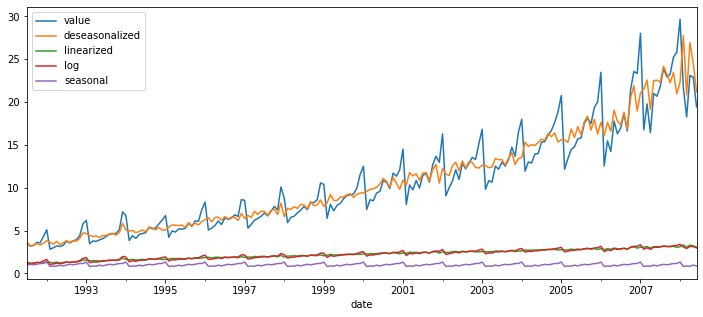

In [127]:
df_augmented.plot(figsize=(12, 5));


In [128]:
# Auto-fit the best SARIMAX with help from this exogenous time series
import pmdarima as pm
sarimax = pm.auto_arima(df[['value']], exogenous=df_augmented[['seasonal']],
                           start_p=0, start_q=0,
                           test='adf',
                           max_p=2, max_q=2, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=627.628, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=626.061, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=598.068, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=613.475, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=759.274, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=598.683, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=593.868, Time=1.11 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=595.603, Time=1.27 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=628.914, Time=0.76 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=549.829, Time=1.29 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=553.329, Time=0.36 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=551.827, Time=1.43 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AI

In [129]:
sarimax.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  204
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood                -257.707
Date:                             Thu, 28 Jul 2022   AIC                            531.414
Time:                                     08:00:28   BIC                            557.474
Sample:                                 07-01-1991   HQIC                           541.969
                                      - 06-01-2008                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0676      0.071      0.950      0.342      -0.072       0.207
seasonal    5.935e-06   7.65e-09    775.543      0.000    5.92e-06    5.95e-06
ar.L1          0.6952      0.073      9.536      0.000       0.552       0.838
ar.L2          0.2739      0.068      4.026      0.000       0.141       0.407
ma.L1         -0.6340      0.063    -10.074      0.000      -0.757      -0.511
ar.S.L12      -0.4900      0.067     -7.339      0.000      -0.621      -0.359
ar.S.L24      -0.2765      0.124     -2.236      0.025      -0.519      -0.034
sigma2         0.8377      0.052     16.195      0.000       0.736       0.939
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               182.17
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              14.88   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.18e+18. Standard errors may be unstable.
"""

In [130]:
# Specific format required by Prophet
df = df.reset_index().rename(columns={'date': 'ds', 'value':'y'})
df.head()

,ds,y,deseasonalized,linearized,log,month
0,1991-07-01,3.526591,3.604047,1.282057,1.260332,7
1,1991-08-01,3.180891,3.213923,1.167492,1.157161,8
2,1991-09-01,3.252221,3.296999,1.193013,1.179338,9
3,1991-10-01,3.611003,3.453824,1.239482,1.283986,10
4,1991-11-01,3.565869,3.315319,1.198554,1.271408,11


In [138]:
from fbprophet import Prophet

train = df.iloc[:176]
test = df.iloc[176:]

model = Prophet(seasonality_mode='multiplicative')

model.fit(train)

ModuleNotFoundError: No module named 'fbprophet'